In [63]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def cargar_datos(csv_path, image_dir, img_size=(224, 224)):
    df = pd.read_csv(csv_path)
    df = df[df['is_dana'] == 'yes']  

    labels = df[['filename', 'level', 'region']].drop_duplicates()
    X, y_level, y_region = [], [], []

    for _, row in labels.iterrows():
        img_path = os.path.join(image_dir, row['filename'])
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB").resize(img_size)
            X.append(np.array(img))
            y_level.append(row['level'])
            y_region.append(row['region'])

    X = np.array(X) / 255.0
    level_enc = LabelEncoder().fit(y_level)
    region_enc = LabelEncoder().fit(y_region)

    y_level_encoded = level_enc.transform(y_level)
    y_region_encoded = region_enc.transform(y_region)

    return X, y_level_encoded, y_region_encoded, level_enc, region_enc

In [64]:
import tensorflow as tf

def crear_modelo(num_levels, num_regions):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    out_level = tf.keras.layers.Dense(num_levels, activation='softmax', name='level')(x)
    out_region = tf.keras.layers.Dense(num_regions, activation='softmax', name='region')(x)

    model = tf.keras.Model(inputs=inputs, outputs=[out_level, out_region])
    model.compile(optimizer='adam',
                  loss={'level': 'sparse_categorical_crossentropy', 'region': 'sparse_categorical_crossentropy'},
                  metrics={'level': 'accuracy', 'region': 'accuracy'})
    return model


In [65]:
def evaluar_modelo(model, X_test, y_level_test, y_region_test):
    results = model.evaluate(X_test, {'level': y_level_test, 'region': y_region_test}, verbose=0)
    print(f"Accuracy del nivel DANA: {results[3]*100:.2f}%")
    print(f"Accuracy de la región afectada: {results[4]*100:.2f}%")


In [66]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from PIL import Image

region_coords = {
    'Región de Murcia': (140, 130, 170, 160),
    'Comunidad Valenciana': (150, 110, 190, 140),
    'Andalucía Oriental': (120, 150, 160, 180),
    'Andalucía Occidental': (70, 150, 110, 180),
    'Extremadura': (60, 120, 100, 150),
    'Castilla-La Mancha': (100, 90, 140, 120),
    'Ávila': (90, 80, 110, 100)
}


def predecir_dana_en_imagen(model, img_path, level_enc, region_enc):
    img = Image.open(img_path).convert('RGB').resize((224, 224))
    arr = np.expand_dims(np.array(img) / 255.0, axis=0)

    pred_level, pred_region = model.predict(arr, verbose=0)
    level = level_enc.inverse_transform([np.argmax(pred_level)])[0]
    region = region_enc.inverse_transform([np.argmax(pred_region)])[0]

    print(f"Región: {region}")
    print(f"Nivel de peligrosidad: {level.upper()}")

    img_cv = np.array(Image.open(img_path).convert("RGB"))
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)


    color = {
    'low': (0, 255, 0),       
    'medium': (0, 255, 255),   
    'high': (255, 0, 0)        
    }.get(level.lower(), (255, 255, 255))

    if region in region_coords:
        x, y, w, h = region_coords[region]
        cv2.rectangle(img_cv, (x, y), (x + w, y + h), color, 3)
    else:
        print("Región no mapeada para dibujar en la imagen.")

    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Predicción IA sobre riesgo de DANA")
    plt.show()


In [67]:
import os
print(os.listdir("IMÁGENES"))


['01-01-2025.png', '01-02-2025.png', '01-03-2025.png', '02-01-2025.png', '02-02-2025.png', '02-03-2025.png', '03-01-2025.png', '03-02-2025.png', '03-03-2025.png', '04-01-2025.png', '04-02-2025.png', '04-03-2025.png', '05-01-2025.png', '05-02-2025.png', '05-03-2025.png', '06-01-2025.png', '06-02-2025.png', '06-03-2025.png', '07-01-2025.png', '07-02-2025.png', '07-03-2025.png', '08-01-2025.png', '08-02-2025.png', '08-03-2025.png', '09-01-2025.png', '09-02-2025.png', '09-03-2025.png', '10-01-2025.png', '10-02-2025.png', '10-03-2025.png', '11-01-2025.png', '11-02-2025.png', '11-03-2025.png', '12-01-2025.png', '12-02-2025.png', '12-03-2025.png', '13-01-2025.png', '13-02-2025.png', '13-03-2025.png', '14-01-2025.png', '14-02-2025.png', '15-01-2025.png', '15-02-2025.png', '16-01-2025.png', '16-02-2025.png', '17-01-2025.png', '17-02-2025.png', '18-01-2025.png', '18-02-2025.png', '19-01-2025.png', '19-02-2025.png', '20-01-2025.png', '20-02-2025.png', '21-01-2025.png', '21-02-2025.png', '22-01-20

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 419ms/step - level_accuracy: 0.9253 - level_loss: 0.3297 - loss: 6.3319 - region_accuracy: 0.0000e+00 - region_loss: 5.9780
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - level_accuracy: 0.9566 - level_loss: 0.6945 - loss: 6.6875 - region_accuracy: 0.1181 - region_loss: 5.8259  
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - level_accuracy: 0.9253 - level_loss: 0.5401 - loss: 2.9537 - region_accuracy: 0.1181 - region_loss: 2.3703
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - level_accuracy: 0.9566 - level_loss: 0.1766 - loss: 1.9768 - region_accuracy: 0.3854 - region_loss: 1.8121
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - level_accuracy: 0.9253 - level_loss: 0.1567 - loss: 1.9993 - region_accuracy: 0.2674 - region_loss: 1.8900
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - level_accuracy: 0.9566 - level_loss: 0.1163 - loss: 1.7664 - region_accuracy: 0.2639 - region_loss: 1.6682
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 3

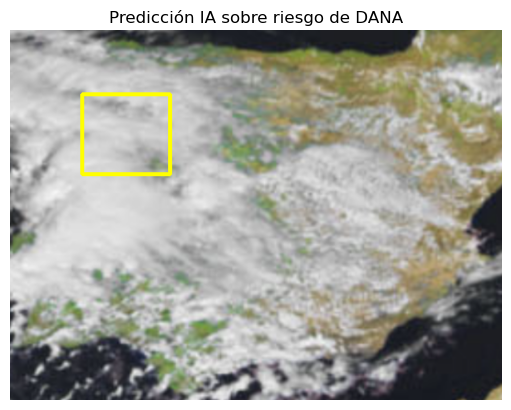

In [75]:
image_dir = "IMÁGENES"
csv_path = "labels_expanded.csv"

X, y_level, y_region, level_enc, region_enc = cargar_datos(csv_path, image_dir)

from sklearn.model_selection import train_test_split
X_train, X_test, y_level_train, y_level_test, y_region_train, y_region_test = train_test_split(
    X, y_level, y_region, test_size=0.2, random_state=42
)

model = crear_modelo(num_levels=len(level_enc.classes_), num_regions=len(region_enc.classes_))
model.fit(X_train, {'level': y_level_train, 'region': y_region_train}, epochs=10, batch_size=8)

evaluar_modelo(model, X_test, y_level_test, y_region_test)

predecir_dana_en_imagen(model, "IMÁGENES/10-03-2025.png", level_enc, region_enc)